### Imports

In [24]:
import os
import sys
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
import time

In [25]:
# import the frank2d directory
current_dir =  os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

#frank2d
from frank2d import Frank2D 
from constants import rad_to_arcsec
from plot import Plot
from fitting import IterativeSolverMethod

# frank1d
import frank
from frank.geometry import FixedGeometry, SourceGeometry, FitGeometryGaussian
from frank.radial_fitters import FrankFitter
from frank.utilities import UVDataBinner

In [26]:
from scipy.sparse.linalg._interface import LinearOperator
from scipy.sparse.linalg._isolve.utils import make_system

### Functions

In [27]:
def deproject(u, v, inc, PA, inverse=False):
    r"""
    Deproject the image in visibily space

    Parameters
    ----------
    u : array of real, size = N, unit = :math:`\lambda`
        u-points of the visibilities
    v : array of real, size = N, unit = :math:`\lambda`
        v-points of the visibilities
    inc : float, unit = deg
        Inclination
    PA : float, unit = deg
        Position angle, defined east of north.
    inverse : bool, default=False
        If True, the uv-points are reprojected rather than deprojected

    Returns
    -------
    up : array, size = N, unit = :math:`\lambda`
        Deprojected u-points
    vp : array, size = N, unit = :math:`\lambda`
        Deprojected v-points
    wp : array of real, size = N, unit = :math:`\lambda`
        Fourier w-points of the deprojected visibilities. Only returned if
        deprojecting.

    """
    deg_to_rad = np.pi / 180
    inc *= deg_to_rad
    PA *= deg_to_rad

    cos_t = np.cos(PA)
    sin_t = np.sin(PA)

    if inverse:
        sin_t *= -1
        u = u / np.cos(inc)

    up = u * cos_t - v * sin_t
    vp = u * sin_t + v * cos_t

    if inverse:
        return up, vp
    else:
    #   Deproject
        wp = up * np.sin(inc)
        up = up * np.cos(inc)

        return up, vp, wp

In [28]:
def apply_phase_shift(u, v, V, dRA, dDec, inverse=False):
    r"""
    Apply a phase shift to the visibilities.

    This is equivalent to moving the source in the image plane by the
    vector (dRA, dDec).

    Parameters
    ----------
    u : array of real, size = N, unit = :math:`\lambda`
        u-points of the visibilities
    v : array of real, size = N, unit = :math:`\lambda`
        v-points of the visibilities
    V : array of real, size = N, unit = Jy
        Complex visibilites
    dRA : float, unit = arcsec
        Phase shift in right ascenion.
    dDec : float, unit = arcsec
        Phase shift in declination.
    inverse : bool, default=False
        If True, the phase shift is reversed (equivalent to
        flipping the signs of dRA and dDec).
    Returns
    -------
    shifted_vis : array of real, size = N, unit = Jy
        Phase shifted visibilites

    """
    dRA *= 2. * np.pi / rad_to_arcsec
    dDec *= 2. * np.pi / rad_to_arcsec

    phi = u * dRA + v * dDec

    if inverse:
        shifted_vis = V / (np.cos(phi) + 1j * np.sin(phi))
    else:
        shifted_vis = V * (np.cos(phi) + 1j * np.sin(phi))

    return shifted_vis

In [29]:
 def apply_correction(self, u, v, V, use3D=False):
        r"""
        Correct the phase centre and deproject the visibilities

        Parameters
        ----------
        u : array of real, size = N, unit = :math:`\lambda`
            u-points of the visibilities
        v : array of real, size = N, unit = :math:`\lambda`
            v-points of the visibilities
        V : array of real, size = N, units = Jy
            Complex visibilites
        use3D : bool, default=False
            If True, also return the 3rd compoent of the
            de-projected visibilities, wp.

        Returns
        -------
        up : array of real, size = N, unit = :math:`\lambda`
            Corrected u-points of the visibilities
        vp : array of real, size = N, unit = :math:`\lambda`
            Corrected v-points of the visibilities
        wp : array of real, size = N, unit = :math:`\lambda`
            [Optional] Corrected w-points of the visibilities
        Vp : array of real, size = N, unit = Jy
            Corrected complex visibilites

        """
        Vp = apply_phase_shift(u, v, V, self._dRA, self._dDec, inverse=True)
        up, vp, wp = deproject(u, v, self._inc, self._PA)

        if use3D:
            return up, vp, wp, Vp
        else:
            return up, vp, Vp

In [30]:
from scipy.stats import binned_statistic

def get_radial_profile(frank_object):
    x_ = frank_object._FT._x*rad_to_arcsec
    y_ = frank_object._FT._y*rad_to_arcsec
    x, y = np.meshgrid(x_, y_, indexing='ij')
    pixel_size = (x[1]-x[0])[0]
    r = np.hypot(x, y)
    I = frank_object.sol_intensity
    r = r.flatten()
    I = I.flatten()
    N = frank_object._Nx
    bin = (np.max(r) - np.min(r))/N
    I_binned, bin_edges, _ = binned_statistic(r, I, 'mean', N)
    r_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return r_centers, I_binned

def get_vis_profile(frank_object):
    u_ = frank_object._FT._u
    v_ = frank_object._FT._v
    u, v = np.meshgrid(u_, v_, indexing='ij')
    pixel_size = (u[1]-u[0])[0]
    q = np.hypot(u, v)
    Vis = frank_object.sol_visibility
    q = q.flatten()
    Vis = Vis.flatten()
    N = frank_object._Nx
    bin = (np.max(q) - np.min(q))/N
    Vis_binned, bin_edges, _ = binned_statistic(q, Vis, 'mean', N)
    q_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return q_centers, Vis_binned

## Upload input

In [32]:
# Huang 2018 
inc = 34.97
pa = 85.76
dra = 1.9e-3
ddec = -2.5e-3
Rout = 3 #arcsecs

# UVtable
dir = "./../../data/"
data_file = dir +'AS209_continuum_prom_1chan_30s_keepflagsFalse.txt'

 # load data||
u, v, Re, Imag, Weights = np.loadtxt(data_file, unpack = True)
Vis = Re + Imag*1j

ud, vd, _ = deproject(u, v, inc, pa)

In [33]:
geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)

In [34]:
u_deproj, v_deproj, vis_deproj = geom.apply_correction(u, v, Vis)

In [35]:
baselines = np.hypot(u_deproj, v_deproj)         
grid = np.logspace(np.log10(min(baselines.min(), baselines[0])),
                           np.log10(max(baselines.max(), baselines[-1])),
                           10**4)
cs, ms = ['#a4a4a4', 'k'], ['.', 'x']
bin_widths=[1e3, 1e5]

In [36]:
def linear_val(x1,y1,x2,y2):
    m = (y2-y1)/(x2-x1)
    c = y2 + m*-x2
    return m, c

def linear(x, m, c):
    return m*x + c

### One fit

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_5814/1128164861.py:9: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(y)
/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_5814/1128164861.py:10: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(x)


<Figure size 640x480 with 0 Axes>

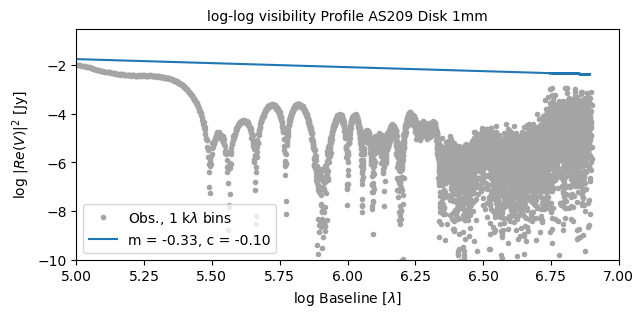

In [37]:
plt.clf()
plt.figure(figsize=(7, 3))

binned_vis = UVDataBinner(baselines, vis_deproj, Weights, bin_widths[0])

x = binned_vis.uv[100:]
y = np.abs(binned_vis.V[100:].real)**2

y = np.log10(y)
x = np.log10(x)

plt.plot(x, y, c=cs[0], marker=ms[0], ls='None', label=r'Obs., {:.0f} k$\lambda$ bins'.format(bin_widths[0]/1e3))

m, c = -0.33, -0.1

plt.plot(x, linear(x, m, c), label = f'm = {m:.2f}, c = {c:.2f}')

plt.axhline(0, c='c', ls='--')
plt.title('log-log visibility Profile AS209 Disk 1mm', size = 10)    
plt.xlabel(r'log Baseline [$\lambda$]', size = 10)
plt.ylabel(r'log $|Re(V)|^{2}$ [Jy]', size = 10)
plt.ylim(-10, -0.5)
plt.xlim(5, 7)
plt.legend(loc = 'best')
plt.show()

In [40]:
l = 1e4
m = -0.33
c = -0.1

In [63]:
frank2d = Frank2D(200, Rout)
frank2d.fit(u_deproj, v_deproj, vis_deproj, Weights, kernel_params=[m, c, l], method = 'cg', rtol = '1e-12')

Gridding...
  --> time = 0.01  min |  0.74 seconds
Setting fit with cg ...
Fitting...
  *  Constructing linear operators...
     --> time = 4.00  min |  239.83 seconds
  *  Solving linear system...
rtol:  1e-12
atol:  0.0
rtol:  1.7753778881581358e-06
final atol:  1.7753778881581358e-06
maxiter:  20
iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
  --> CGM converged in  8  iterations
     --> time = 15.66  min |  939.53 seconds
  --> CGM converged?   True
  --> Fit correctly?   True
                                                !!!!!!!!!!!      fit correctly       !!!!!!!!
Inverting with 2fft ...
  --> time = 0.00  min |  0.00 seconds


In [84]:
import os
os. getcwd()

'/Users/mariajmelladot/Desktop/Frank2D/6_Frank2D_Oficial/Notebooks'

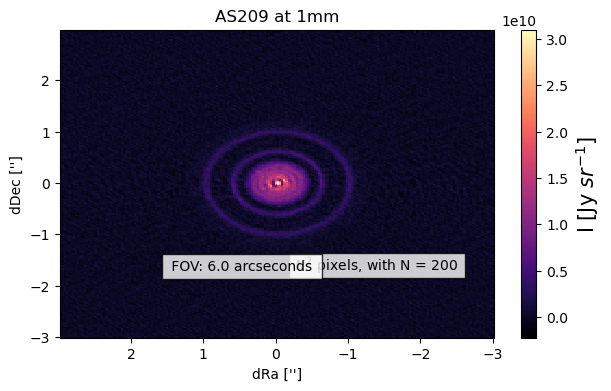

In [64]:
Plot(frank2d).get_image('AS209 at 1mm')

In [62]:
#frank2d_2 = Frank2D(100, Rout)
#frank2d_2.fit(u_deproj, v_deproj, vis_deproj, Weights, kernel_params=[m, c, 1.5e4])

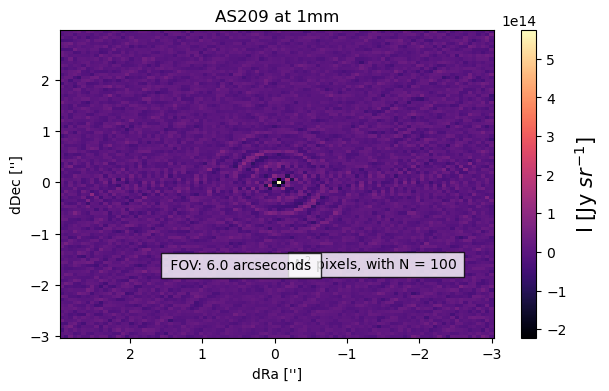

In [20]:
Plot(frank2d_2).get_image('AS209 at 1mm')

In [43]:
# Frank 1D Parameters
n_pts = 300
alpha = 1.3
w_smooth = 1e-1

geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)
FF = FrankFitter(Rout, n_pts, geom, alpha = alpha, weights_smooth = w_smooth)
sol = FF.fit(u, v, Vis, Weights)

In [65]:
# Frank2D
r, I = get_radial_profile(frank2d)
#r_2, I_2 = get_radial_profile(frank2d_2)

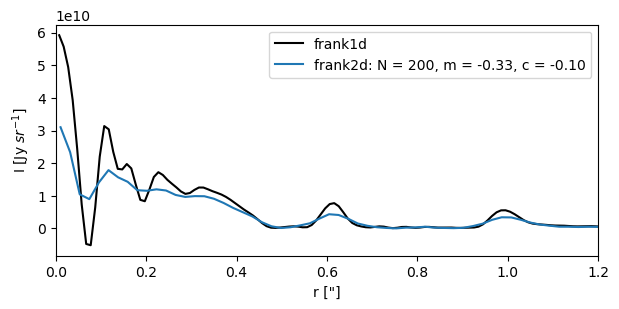

In [66]:
plt.figure(figsize=(7,3))
plt.plot(sol.r, sol.mean, 'black',label ='frank1d')
plt.plot(r, I, label = f'frank2d: N = {200}, m = {m:.2f}, c = {c:.2f}')
#plt.plot(r_2, I_2, label = f'frank2d: N = {100}, m = {m:.2f}, c = {c:.2f}')
plt.xlabel('r ["]')
plt.xlim(0, 1.2)
plt.ylabel(r'I [Jy $sr^{-1}$]')
plt.legend()
plt.show()

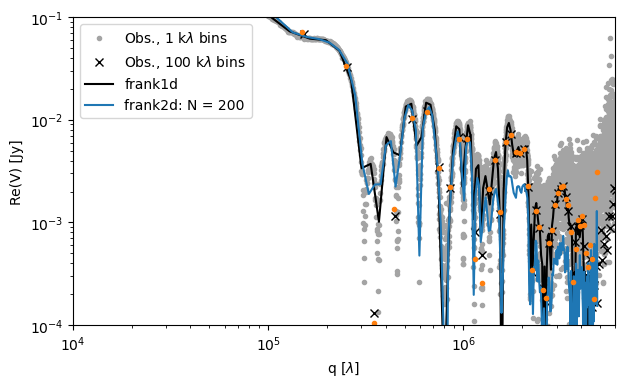

In [67]:
plt.figure(figsize=(7,4))

for i in range(len(bin_widths)):
            binned_vis = UVDataBinner(baselines, vis_deproj, Weights, bin_widths[i])
            plt.plot(binned_vis.uv, np.abs(binned_vis.V), c=cs[i],
                         marker=ms[i], ls='None', 
                         label=r'Obs., {:.0f} k$\lambda$ bins'.format(bin_widths[i]/1e3))

u_gridded = frank2d._gridded_data['u']
v_gridded = frank2d._gridded_data['v']
vis_gridded = frank2d._gridded_data['vis']
weights_gridded = frank2d._gridded_data['weights']
baselines_gridded = np.hypot(u_gridded, v_gridded)
binned_vis_gridded = UVDataBinner(baselines_gridded, vis_gridded, weights_gridded, bin_widths[1])
#plt.plot(binned_vis_gridded.uv, np.abs(binned_vis_gridded.V),  marker='.', ls='None')

vis_fit_1d = sol.predict_deprojected(sol.q)
baselines_fit_1d = sol.q
plt.plot(baselines_fit_1d, np.abs(vis_fit_1d), color = "black", label = r'frank1d')

q, Vis = get_vis_profile(frank2d)
plt.plot(q, np.abs(Vis.real), label = f'frank2d: N = 200')#, m = {m:.2f}, c = {c:.2f}')

#q_2, Vis_2 = get_vis_profile(frank2d_2)
#plt.plot(q_2, Vis_2.real, label = f'frank2d: N = 100, m = {m:.2f}, c = {c:.2f}')

plt.plot(binned_vis_gridded.uv, np.abs(binned_vis_gridded.V),  marker='.', ls='None')

plt.xlabel(r'q [$\lambda$]')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-4, 0.1)
plt.xlim(1e4, 6e6)
plt.ylabel('Re(V) [Jy]', size = 10)
plt.legend()
plt.show()

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_5814/3644899950.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift(vis_gridded.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)


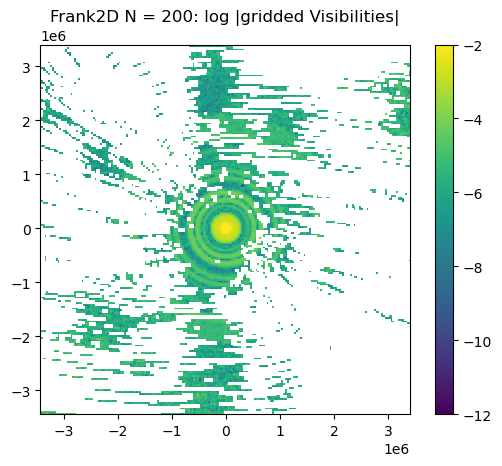

In [81]:
plt.figure()
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_gridded.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)
plt.title("Frank2D N = 200: log |gridded Visibilities|")
plt.colorbar()

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_5814/1598080632.py:3: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift(frank2d.sol_visibility.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)


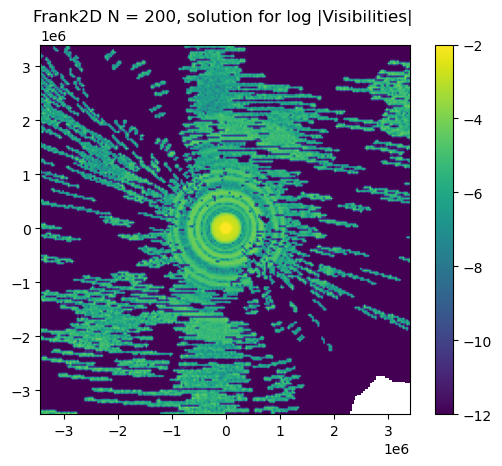

In [80]:
N = 200
extent=[u_gridded.min(), u_gridded.max(), v_gridded.min(), v_gridded.max()]
plt.imshow(np.log(np.abs(np.fft.fftshift(frank2d.sol_visibility.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)
plt.title("Frank2D N = 200, solution for log |Visibilities| ")
plt.colorbar()

In [60]:
np.log(np.abs(np.fft.fftshift(frank2d.sol_visibility.reshape(N, N))))

array([[ -6.00347308,  -6.5030138 ,  -5.31669585, ...,  -5.8472195 ,
         -6.29485821,  -5.69571415],
       [ -5.31068025,  -5.13451359,  -5.93572775, ...,  -6.17373648,
        -11.75654933, -11.77153951],
       [ -5.11649789,  -7.33280454,  -6.23452084, ...,  -6.39017282,
        -12.46907284, -19.37548215],
       ...,
       [ -5.72782559, -10.97498296, -16.90459599, ...,  -6.81198755,
         -5.2786573 , -11.92235194],
       [-11.80757541, -17.53093236, -19.32058787, ..., -11.18536075,
        -11.26125423, -11.15856276],
       [-19.58064483, -24.79320873, -20.75333543, ...,  -5.02971839,
         -7.29074754,  -5.08145131]])

## All

In [32]:
m1, c1 = linear_val(5.3, -2.5, 5.7, -3)
m2, c2 = linear_val(5.3, -2.5, 5.9, -3.5)
m3, c3 = linear_val(5.3, -2.5, 5.9, -3)
m4, c4 = linear_val(5.3, -2, 5.9, -2.2)
m5, c5 = linear_val(5.3, -1.9, 5.9, -2.7)
m6, c6 = linear_val(5.3, -2.5, 5.9, -4)
m7, c7 = linear_val(5.3, -2.5, 5.9, -2)
m8, c8 = linear_val(5.3, -2.5, 5.9, -2.1)
m9, c9 = linear_val(5.3, -2.5, 5.9, -3)
m10, c10 = linear_val(5.3, -1.21, 5.9, -2.7)
m11, c11 = linear_val(5.25, -3, 5.9, -4)
m12, c12 = linear_val(5.25, -3, 5.9, -3.5)
m13, c13 = linear_val(5.25, -3, 5.9, -4.5)
m15, c15 = linear_val(5.3, -3, 5.9, -4)
m16, c16 = linear_val(5.3, -1, 5.9, -1.2)
m17, c17 = -1.67, 6.83
m18, c18 = -1.33, 5.17
m19, c19 = -1.25, 4.12
m20, c20 = -1, 3.2
m21, c21 = -0.83, 1.92
m22, c22 = -0.5, 0.5
m23, c23 = -0.33, -0.1
m24, c24 = -0.1, -2.5
m25, c25 = -0.1, -3

m1, c1 =-1, 2.2
m2, c2 = -1, 4.2
m3, c3 = -1, 5.2
m, c = -0.33, -0.1

In [33]:
m_array_ = [m]
c_array_ = [c]
size_ =  len(m_array_)

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_55750/1479469903.py:9: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(y)
/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_55750/1479469903.py:10: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(x)


<Figure size 640x480 with 0 Axes>

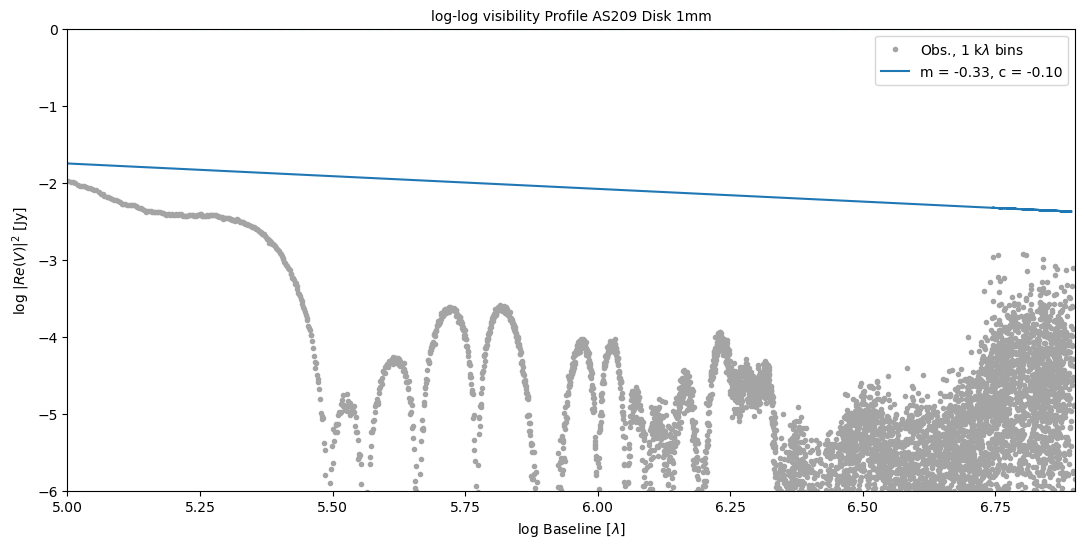

In [34]:
plt.clf()
plt.figure(figsize=(13, 6))

binned_vis = UVDataBinner(baselines, vis_deproj, Weights, bin_widths[0])

x = binned_vis.uv[100:]
y = np.abs(binned_vis.V[100:].real)**2

y = np.log10(y)
x = np.log10(x)

plt.plot(x, y, c=cs[0], marker=ms[0], ls='None', label=r'Obs., {:.0f} k$\lambda$ bins'.format(bin_widths[0]/1e3))

for i in range(0, len(m_array_)):
    plt.plot(x, linear(x, m_array_[i], c_array_[i]), label = f'm = {m_array_[i]:.2f}, c = {c_array_[i]:.2f}')

plt.axhline(0, c='c', ls='--')
plt.title('log-log visibility Profile AS209 Disk 1mm', size = 10)    
plt.xlabel(r'log Baseline [$\lambda$]', size = 10)
plt.ylabel(r'log $|Re(V)|^{2}$ [Jy]', size = 10)
plt.ylim(-6, 0)
plt.xlim(5, 6.9)
plt.legend(loc = 'best')
plt.show()

Gridding...
  --> time = 0.00  min |  0.29 seconds
Setting kernel...
Setting fit method...
Fitting...
  *  Constructing linear operators...
     --> time = 0.09  min |  5.17 seconds
  *  Solving linear system...
atol:  0.0
rtol:  0.004100634562849532
final atol:  0.004100634562849532
maxiter:  64000
  --> CGM converged in  2  iterations
     --> time = 0.09  min |  5.43 seconds
  --> CGM converged?   True
  --> Fit correctly?   True
                                                 fit correctly       !!!!!!
Inverting...
  --> time = 0.00  min |  0.00 seconds
Gridding...
  --> time = 0.00  min |  0.23 seconds
Setting kernel...
Setting fit method...
Fitting...
  *  Constructing linear operators...
     --> time = 0.08  min |  4.64 seconds
  *  Solving linear system...
atol:  0.0
rtol:  0.0015085391514293876
final atol:  0.0015085391514293876
maxiter:  64000
  --> CGM converged in  2  iterations
     --> time = 0.08  min |  4.78 seconds
  --> CGM converged?   True
  --> Fit correctly?   T

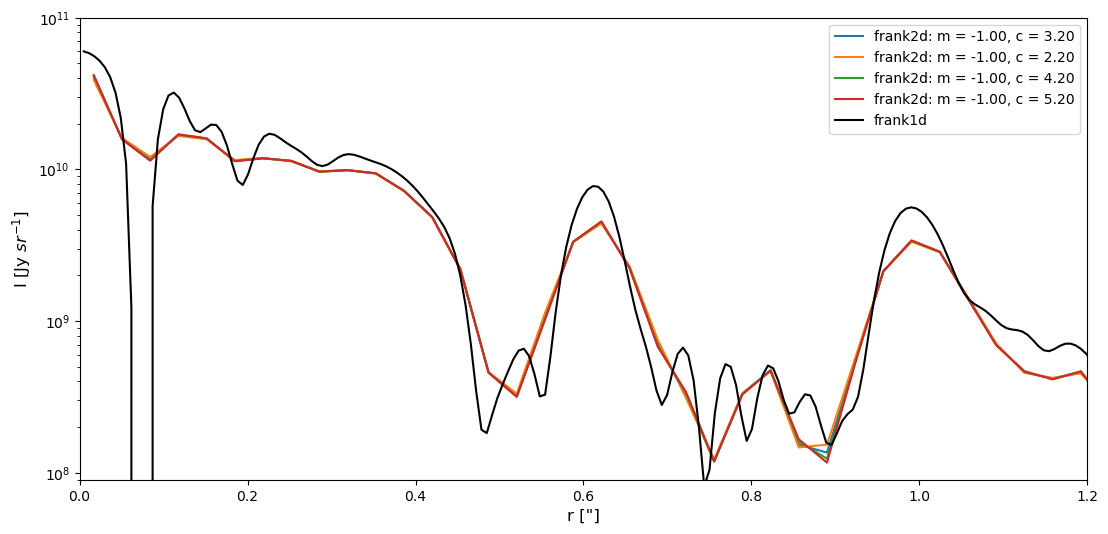

In [435]:
plt.figure(figsize = (13, 6))
N = 80
frank_objects = []
for i in range(0, size_):
    frank2d = Frank2D(N, Rout)
    frank2d.fit(u_deproj, v_deproj, vis_deproj, Weights, rtol = 1e-7, transform = "2fft", kernel_params=[m_array_[i], c_array_[i], 1e4])
    r, I = get_radial_profile(frank2d)
    frank_objects.append(frank2d)
    plt.plot(r, I, label = f'frank2d: m = {m_array_[i]:.2f}, c = {c_array_[i]:.2f}')
plt.plot(sol.r, sol.mean, 'black', label ='frank1d')

    
plt.xlabel('r ["]', size = 12)
plt.xlim(0, 1.2)
plt.ylabel(r'I [Jy $sr^{-1}$]', size= 12)
plt.yscale('log')
plt.ylim(0.9e8, 1e11)
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

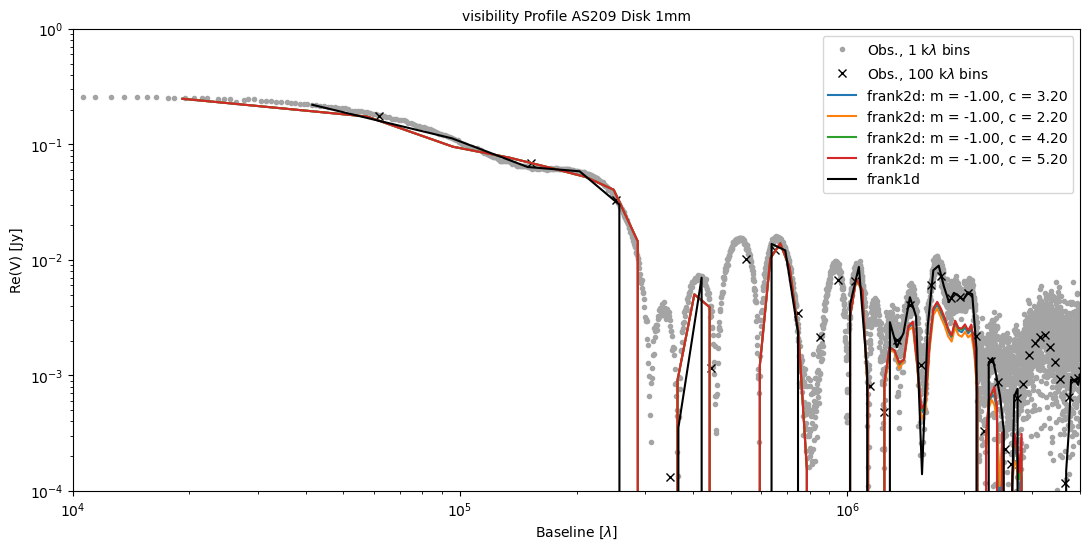

In [436]:
plt.clf()
plt.figure(figsize=(13,6))

for i in range(len(bin_widths)):
            binned_vis = UVDataBinner(baselines, vis_deproj, Weights, bin_widths[i])
            plt.plot(binned_vis.uv, np.abs(binned_vis.V), c=cs[i],
                         marker=ms[i], ls='None', 
                         label=r'Obs., {:.0f} k$\lambda$ bins'.format(bin_widths[i]/1e3))

for i in range(0, len(frank_objects)):
    q, Vis = get_vis_profile(frank_objects[i])
    plt.plot(q, Vis.real, label = f'frank2d: m = {m_array_[i]:.2f}, c = {c_array_[i]:.2f}')


vis_fit_1d = sol.predict_deprojected(sol.q)
baselines_fit_1d = sol.q
plt.plot(baselines_fit_1d, vis_fit_1d, color = "black", label = r'frank1d')


plt.axhline(0, c='c', ls='--')
plt.title('visibility Profile AS209 Disk 1mm', size = 10)    
plt.xlabel(r'Baseline [$\lambda$]', size = 10)
plt.ylabel('Re(V) [Jy]', size = 10)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e4, 4e6)
plt.ylim(1e-4, 1)
plt.legend()
plt.show()

### Changing $l$

In [420]:
m, c = m4, c4
N = 100
np.random.seed(0)
l_array = np.random.uniform(1e4, 1e5, 5)

In [421]:
l_array

array([59393.21535346, 74367.04297352, 64248.70384645, 59039.48646972,
       48128.9319405 ])

In [423]:
plt.figure(figsize = (13, 6))
frank2d = Frank2D(N, Rout)
for i in range(0, len(l_array)):
    frank2d.fit(u_deproj, v_deproj, vis_deproj, Weights, rtol = 1e-5, kernel_params=[m, c, l_array[i]])
    r, I = get_radial_profile(frank2d)
    plt.plot(r, I, label = f'frank2d: m = {m:.2f}, c = {c:.2f}, l = {l_array[i]:.2e}')
    
plt.plot(sol.r, sol.mean, 'black', label ='frank1d')

plt.xlabel('r ["]', size = 12)
plt.xlim(0, 1.2)
plt.ylabel(r'I [Jy $sr^{-1}$]', size= 12)
plt.yscale('log')
plt.ylim(0.9e8, 1e11)
plt.legend()
plt.show()


Gridding...
  --> time = 0.01  min |  0.39 seconds
Setting kernel...
Setting fit method...
Fitting...
  *  Constructing linear operators...
     --> time = 0.30  min |  18.05 seconds
  *  Solving linear system...
atol:  0.0
rtol:  111.2950281623188
final atol:  111.2950281623188
maxiter:  100000


KeyboardInterrupt: 

<Figure size 1300x600 with 0 Axes>

### CLEAN

In [86]:
# Obtain the radial profiles convolved to a circular beam.
from gofish import imagecube

infile_1mm = dir + 'AS209_1mm_13s_conv_circ.fits'
#2D->1D
cube_1mm = imagecube(infile_1mm)
x_1mm,y_1mm,dy_1mm = cube_1mm.radial_profile(inc=inc, PA=pa, x0=dra, y0=ddec)

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


#### Convolve Frank Profiles

In [87]:
from frank.utilities import convolve_profile

clean_beam_1mm = {'bmaj':0.0373, 'bmin':0.0373, 'beam_pa':31.040}
area_1mm = clean_beam_1mm['bmaj']*clean_beam_1mm['bmin']*np.pi/4./np.log(2.)*(1/rad_to_arcsec)**2

convolved_1mm_frank1d = convolve_profile(sol.r, sol.mean, inc, pa, clean_beam_1mm)*area_1mm
convolved_1mm_frank2d = convolve_profile(r_centers, I_binned, inc, pa, clean_beam_1mm)*area_1mm

#### Compare profiles

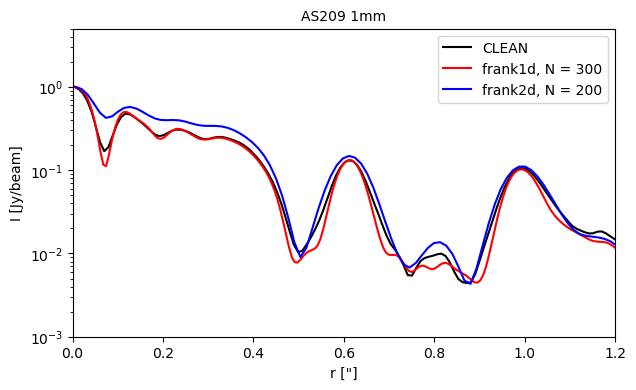

In [89]:
plt.figure(figsize=(7, 4))
plt.plot(x_1mm, y_1mm/np.max(y_1mm), "black", label = "CLEAN")
#plt.fill_between(x_1mm, y_1mm-dy_1mm, y_1mm+dy_1mm,alpha=0.7)
plt.plot(sol.r, convolved_1mm_frank1d/np.max(convolved_1mm_frank1d), "red", label=r'frank1d' + ', N = ' +str(n_pts))
plt.plot(r_centers,convolved_1mm_frank2d/np.max(convolved_1mm_frank2d), "blue", label=r'frank2d' + ', N = ' +str(N))
plt.title(r'AS209 1mm', size=10)
plt.ylabel("I [Jy/beam]", size=10)
plt.xlabel('r ["]', size=10)
plt.legend(fontsize=10)
plt.yscale('log')
plt.ylim(1e-3, 0.5e1)
plt.xlim(0,1.2)
plt.show()